<center> Using LSTM to predict Bitcoin Price <center>

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.layers import LeakyReLU, Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.optimizers import Adam

In [45]:
# Loading Bitcoin prices into a dataframe

data = pd.read_csv('BTC-USD.csv')
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-10-01,10795.254883,10933.624023,10472.356445,10619.452148,10619.452148,40023134100
1,2020-10-02,10619.821289,10657.837891,10416.689453,10575.974609,10575.974609,48661453918
2,2020-10-03,10575.100586,10598.940430,10511.129883,10549.329102,10549.329102,44660271563
3,2020-10-04,10550.440430,10686.000000,10534.391602,10669.583008,10669.583008,71251776995
4,2020-10-05,10676.529297,10793.507813,10634.600586,10793.339844,10793.339844,47537578009


In [46]:
# Close data of Bitcoin is what we will focus on
close_data = data[['Close']]
close_data.head(5)

,Close
0,10619.452148
1,10575.974609
2,10549.329102
3,10669.583008
4,10793.339844


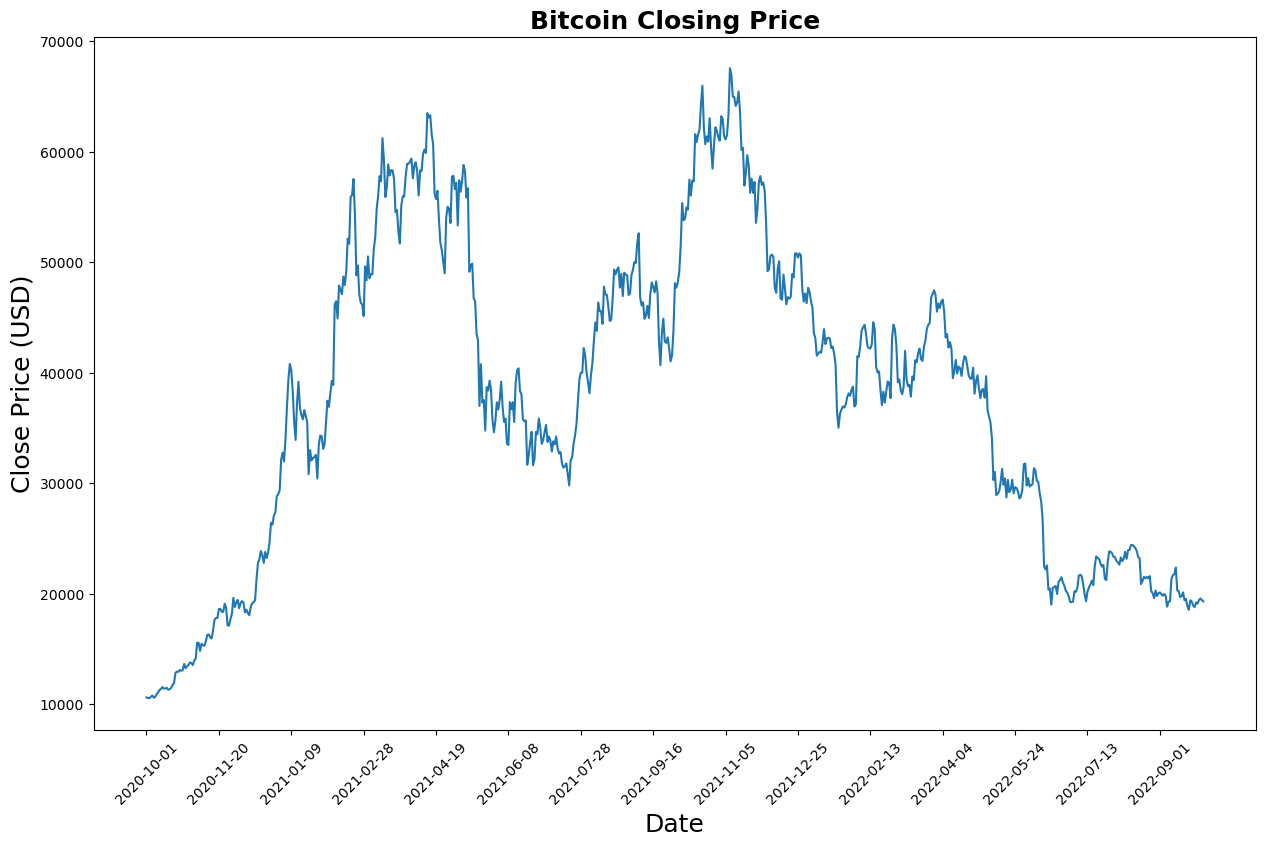

In [47]:
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0, data.shape[0],50), data['Date'].loc[::50],rotation=45)
plt.title("Bitcoin Closing Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [48]:
# Normalize values
mms = MinMaxScaler()

n_data = mms.fit_transform(close_data.values)

In [49]:
# Split data into training and testing

def univariate_data(dataset, start, end, history_size, target_size):
    udata = []
    labels = []

    start = start + history_size
    if end is None:
        end = len(dataset) - target_size

    for i in range(start, end):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        udata.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(udata), np.array(labels) 

past_history = 5
future_target = 0

train_split = int(len(n_data) * 0.8)

x_train, y_train = univariate_data(n_data,0,train_split,past_history,future_target)

x_test, y_test = univariate_data(n_data,train_split,None,past_history,future_target)

In [50]:
# Building the model

num_units = 64
learning_rate = 0.0001
activation_function = 'sigmoid'
adam = Adam(learning_rate)
loss_function = 'mse'
batch_size = 5
num_epochs = 50

# Initialize the RNN
model = Sequential()
model.add(LSTM(units = num_units, activation=activation_function, input_shape=(None, 1)))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.1))
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer=adam, loss=loss_function) 

In [51]:
# Training the model
history = model.fit(x_train,y_train,validation_split=0.1,batch_size=batch_size,epochs=num_epochs,shuffle=False)

Epoch 1/50
105/105 [==============================] - 7s 14ms/step - loss: 1.1378 - val_loss: 0.4074
Epoch 2/50
105/105 [==============================] - 1s 8ms/step - loss: 0.2475 - val_loss: 0.0391
Epoch 3/50
105/105 [==============================] - 1s 8ms/step - loss: 0.0955 - val_loss: 0.0027
Epoch 4/50
105/105 [==============================] - 1s 8ms/step - loss: 0.0936 - val_loss: 0.0034
Epoch 5/50
105/105 [==============================] - 1s 8ms/step - loss: 0.0877 - val_loss: 0.0055
Epoch 6/50
105/105 [==============================] - 1s 8ms/step - loss: 0.0935 - val_loss: 0.0062
Epoch 7/50
105/105 [==============================] - 1s 8ms/step - loss: 0.0873 - val_loss: 0.0073
Epoch 8/50
105/105 [==============================] - 1s 8ms/step - loss: 0.0913 - val_loss: 0.0067
Epoch 9/50
105/105 [==============================] - 1s 8ms/step - loss: 0.0853 - val_loss: 0.0086
Epoch 10/50
105/105 [==============================] - 1s 8ms/step - loss: 0.0819 - val_loss: 0.005

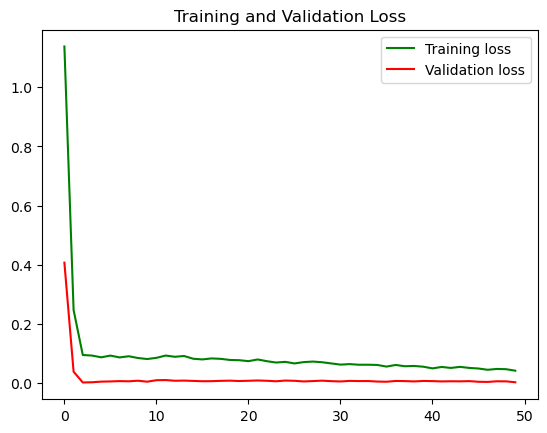

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss,'g',label='Training loss')
plt.plot(epochs, val_loss,'r',label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

5/5 [==============================] - 0s 5ms/step


Text(0, 0.5, 'Price (USD)')

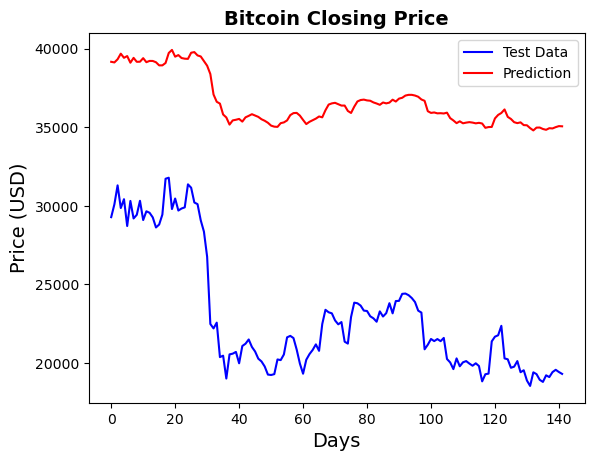

In [55]:
original = pd.DataFrame(mms.inverse_transform(y_test))
predictions = pd.DataFrame(mms.inverse_transform(model.predict(x_test)))

ax = sns.lineplot(x=original.index, y=original[0], label="Test Data", color='blue')
ax = sns.lineplot(x=predictions.index, y=predictions[0], label="Prediction", color='red')
ax.set_title('Bitcoin Closing Price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price (USD)", size = 14)